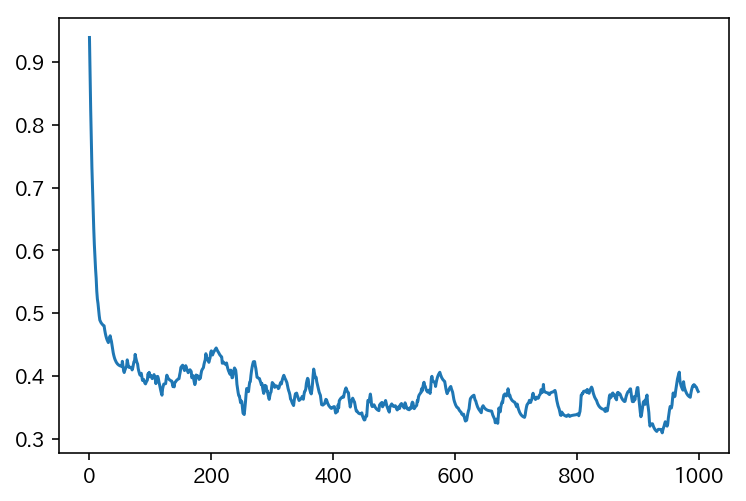

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib.bayesflow import hmc
%matplotlib inline
# Empirical-Bayes estimation of a hyperparameter by MCMC-EM:

# Problem setup
N = 150
D = 10
x = np.random.randn(N, D).astype(np.float32)
true_sigma = 0.5
true_beta = true_sigma * np.random.randn(D).astype(np.float32)
y = x.dot(true_beta) + np.random.randn(N).astype(np.float32)

def log_prior(beta, log_sigma):
    return tf.reduce_sum(-0.5 / tf.exp(2 * log_sigma) * tf.square(beta) -
                       log_sigma)
def regression_log_joint(beta, log_sigma, x, y):
    means = tf.matmul(tf.expand_dims(beta, 0), x, transpose_b=True)
    means = tf.squeeze(means)
    log_likelihood = tf.reduce_sum(-0.5 * tf.square(y - means))
    return log_prior(beta, log_sigma) + log_likelihood
def log_joint_partial(beta):
    return regression_log_joint(beta, log_sigma, x, y)
# Our estimate of log(sigma)
log_sigma = tf.Variable(0., name='log_sigma')
# The state of the Markov chain
beta = tf.Variable(tf.random_normal([x.shape[1]]), name='beta')
new_beta, _, _, _ = hmc.kernel(0.1, 5, beta, log_joint_partial,
                               event_dims=[0])
beta_update = tf.assign(beta, new_beta)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
with tf.control_dependencies([beta_update]):
    log_sigma_update = optimizer.minimize(-log_prior(beta, log_sigma),
                                        var_list=[log_sigma])

sess = tf.Session()
sess.run(tf.global_variables_initializer())
log_sigma_history = np.zeros(1000)
for i in range(1000):
    log_sigma_val, _ = sess.run([log_sigma, log_sigma_update])
    log_sigma_history[i] = log_sigma_val
# Should converge to something close to true_sigma
plt.plot(np.exp(log_sigma_history))

In [3]:
tf.__version__

'1.5.0'

In [9]:
help(hmc.ais_chain)

Help on function ais_chain in module tensorflow.contrib.bayesflow.python.ops.hmc_impl:

ais_chain(n_iterations, step_size, n_leapfrog_steps, initial_x, target_log_prob_fn, proposal_log_prob_fn, event_dims=(), name=None)
    Runs annealed importance sampling (AIS) to estimate normalizing constants.
    
    This routine uses Hamiltonian Monte Carlo to sample from a series of
    distributions that slowly interpolates between an initial "proposal"
    distribution
    
    `exp(proposal_log_prob_fn(x) - proposal_log_normalizer)`
    
    and the target distribution
    
    `exp(target_log_prob_fn(x) - target_log_normalizer)`,
    
    accumulating importance weights along the way. The product of these
    importance weights gives an unbiased estimate of the ratio of the
    normalizing constants of the initial distribution and the target
    distribution:
    
    E[exp(w)] = exp(target_log_normalizer - proposal_log_normalizer).
    
    Args:
      n_iterations: Integer number of Marko